### 0. Import

##### Setting Route

In [4]:
pwd

'/Users/kangjiwon/Desktop/LG Aimers'

In [2]:
cd ../../..

/Users/kangjiwon/Desktop/LG Aimers


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


##### Settign Module

In [6]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pickle

from euqipment import Enquipment

In [7]:
df = pd.read_csv('phase2_module/data/train.csv')
eq = Enquipment(df)

In [8]:
from phase2_module.src.utils.dataset import Data
from phase2_module.src.models.classification.models import Model
from phase2_module.src.base import BasePiepline
# from phase2_module.src.hyper_parameters.params_optimization import xgboost_opt, set_params_optimization_data
from phase2_module.src.utils.set_seed import seed_everything
from phase2_module.src.utils.top_score_instance import check_the_score

from phase2_module.src.utils.manage_pkl_files import PickleManager as pkl_manager
from phase2_module.src import preprocess
seed_everything()  # NOTE: default 42
_model = Model()

In [9]:
import pandas as pd
import numpy as np
import re, pickle
import warnings
from tqdm import tqdm

In [30]:
pkls = pkl_manager.map(pkl_manager.loads, pkl_manager.metadata_directory)

In [10]:
def set_up(mode= None):
    pd.set_option('display.max_columns', mode)
set_up()

In [11]:
warnings.filterwarnings('ignore')
%matplotlib inline

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('float_format', '{:.2f}'.format)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 120)

##### Dataframe Load

In [12]:
df = eq.df
raw_df = eq.raw_df()

In [13]:
# 동일한 column 제거
raw_df.drop('customer_country.1', axis=1, inplace=True)
# df_test.drop('customer_country.1', axis=1, inplace=True)

In [32]:
basic = preprocess.Basic

In [33]:
runtime_instance = {
    "Train": raw_df,
    "Instances":[
        {"instance": basic, "method": ['drop_duplicated'], "params": False},
    ]
}
raw_df = preprocess.runner('Train',**runtime_instance)

In [39]:
runtime_instance = {
    "Train": raw_df,
    "Instances":[
        {"instance": basic, "method": ['drop_duplicated'], "params": False},
        {"instance": country, "method": ['apply'], "params": pkls.get("country")},
        {"instance": inquiry, "method": ["apply"], "params": False},
        {"instance": product_category, "method": ["product_categories", 'fill_odds'], "params": {**pkls.get("product_category"), **pkls.get("product_subcategory")}},
        {"instance": customer, "method": ["apply"], "params": pkls.get("customer")},
        {"instance": categorization, "method": ["apply"], "params": False},
        # {"instance": convert_ratio, "method": ["lead_owner","customer_idx",'lead_owner_customer_idx_means'], "params": {**pkls.get("lead_owner"), **pkls.get("customer_idx")}},
        # {"instance": basic, "method": ['cusotmer_idx_categorization','customer_idx_merge_enterprise'], "params": False},
    ]
}

In [41]:
raw_df = preprocess.runner('Train',**runtime_instance)

### 1. Data PreProcessing

#### 1.1 Missing Value

In [14]:
eq.is_na(*list(raw_df.columns))

,null
bant_submit,0
business_area,40882
business_subarea,53773
business_unit,0
customer_country,982
customer_idx,0
customer_job,18733
customer_position,0
customer_type,43961
enterprise,0


In [15]:
null_cols = raw_df.columns[raw_df.isnull().any()]

In [16]:
not_null_cols = set(raw_df.columns).difference(set(null_cols))

##### **1.1.1  Customer Type**

In [17]:
# 강지원씨
customer = preprocess.Customer

In [18]:
customer_cols = ['customer_job','customer_position','customer_type']
null_cols = eq.missing_columns(null_cols, customer_cols)

##### **1.1.2 Customer Country**

In [19]:
# 고건영씨
country = preprocess.Country

In [20]:
country_cols = ['customer_country','response_corporate']
null_cols = eq.missing_columns(null_cols, country_cols)

##### **1.1.3 Product Type**

In [21]:
# 오승범씨
product_category = preprocess.ProductCategory

In [22]:
product_cols = ['product_category','product_subcategory','product_modelname']
null_cols = eq.missing_columns(null_cols, product_cols)

##### **1.1.4 Inquiry Type**

In [35]:
# 이주환씨
inquiry = preprocess.Inquiry

In [37]:
inquiry_cols = ['inquiry_type','expected_timeline']
null_cols = eq.missing_columns(null_cols, inquiry_cols)

##### **1.1.5 Busniess Type**

In [26]:
business_cols = ['business_area','business_subarea']

##### 1.1.5 

In [27]:
null_cols

{'business_area', 'business_subarea', 'historical_existing_cnt'}

In [28]:
eq.describe_columns(*not_null_cols)

lead_owner: 영업 담당자 이름
lead_desc_length: 고객이 작성한 Lead Descriptoin 텍스트 총 길이
customer_idx: 고객의 회사명
enterprise: Global 기업인지, Small/Medium 규모의 기업인지
is_converted: 영업 성공 여부. True일 시 성공.
bant_submit: MQL 구성 요소 중 Budget(예산), Title(고객의 직책/직급), Needs(요구사항), Timeline(희망 납기일)에 대한 값의 비율
response_corporate: 담당 자사 법인명
customer_position: 고객의 회사 직책
business_unit: MQL 요청 상품에 대응되는 사업부


#### 1.2 Categorize

##### **1.2.1 Customer_idx**

In [29]:
categorization = preprocess.Categorization

#### 상관관계

In [16]:
# 숫자형 데이터를 포함하는 열(column)의 이름을 추출
numeric_columns = raw_df.select_dtypes(include='number').columns.tolist()

In [17]:
numertic_data = raw_df[numeric_columns]

<Axes: >

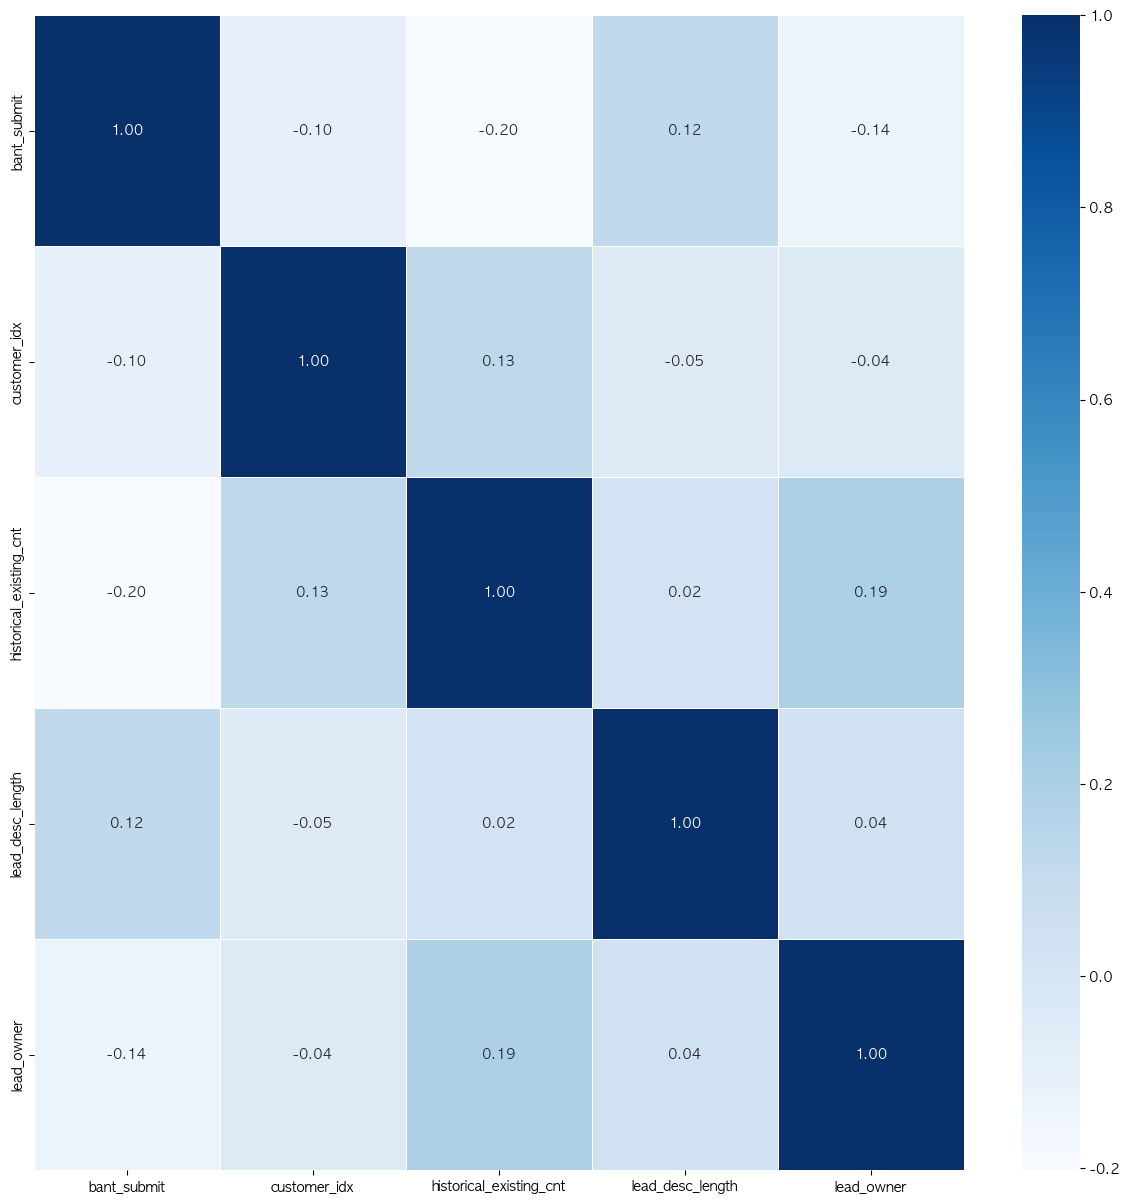

In [18]:
plt.figure(figsize=(15,15))
sns.heatmap(data = numertic_data.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

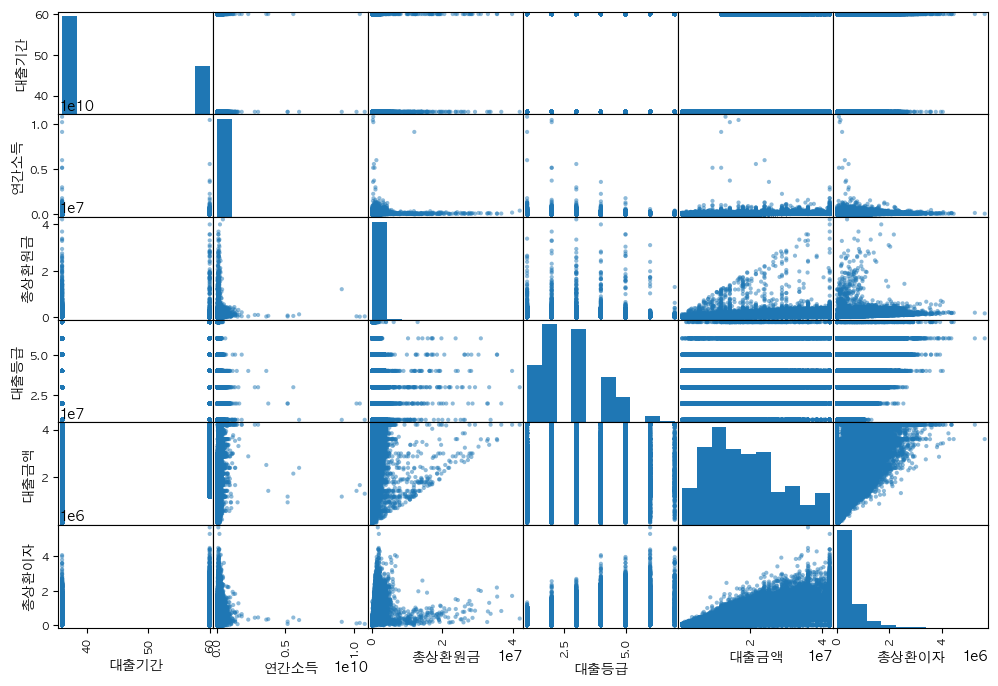

In [165]:
# 상관관계
from pandas.plotting import scatter_matrix

high_corr = df[['대출기간', '연간소득', '총상환원금', '대출등급', '대출금액', '총상환이자']]
scatter_matrix(high_corr, figsize=(12,8))
plt.show()